<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Differences - Grid-Staggering Elastic 2D</div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>


---

This notebook is a private extension writen by Yajian Gao based on part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.


##### Authors:
* Ashim Rijal ([@ashimrijal](https://github.com/ashimrijal))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))
* Yajian Gao

This exercise covers the following aspects:

* Solving velocity-stress formulation of 2D wave equation with finite difference method
* Understanding the grid-staggering in connection with finite difference solution to the elastic wave equation
---

### Exercise
First understand the codes below and run the simulation. 

Then, improve the result using (4-point operator) for 1st derivative.

**Message: Once you become familiar with all the codes below you can go to the Cell tab on the toolbar and click Run All.**


In [1]:
# Configuration step (Please run it before the simulation code!)
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
from matplotlib import cm


In [2]:
# Initialization of parameters

# Simple finite difference solver
# Elastic wave equation
# 2-D regular staggered grid

# Basic parameters
nt = 3000                                       # number of time steps
nx = 1000                                             # number of grid points in x
nz = 400
                                              # velocity (m/sec) (compression wave)
vp=np.zeros((nx,nz))+7000
vs=np.zeros((nx,nz))+5000
rho0=5000
irx=np.linspace(200,900,15)
irz=np.zeros(18)+(nz-3)

dx=1000                                          #m
dz=1000





isnap = 3                                              # snapshot frequency
isx = 200                                     # source location
isz = 200 


#####stable creterias
f0 =  np.max(vp)/dx/20
eps = 0.4
dt=eps*dx/np.max(vp)
dt_stable=dx/(7/6)/np.sqrt(2)/3000
print('f0=',f0)
print('dt=',dt)
print('dt_stable=',dt_stable)


nop = 10                                                # number of operator either 2 or 4


x = (np.arange(nx)*dx)                                 # initialize space coordinates 
z = (np.arange(nz)*dz)
                                     # calculate time step from stability criterion(s)



# Source time function
t = (np.arange(nt) * dt)                             # initialize time axis
T0 = 1. / f0                                           # period
a = 4. / T0                                            # half-width (so called sigma)
t0 = T0 / dt
tmp = np.zeros(nt)
for it in range(nt):
    t = (it - t0) * dt
    tmp[it] = -2 * a * t * np.exp(-(a * t) ** 2)       # derivative of Gaussian (so called sigma)
src = np.zeros(nt)                                     # source
src[0:len(tmp)] = tmp
lam = np.max(vp) * T0                                          # wavelength


#####source term in space
mxx=1e6/dx/dz
mzz=1e6/dx/dz






f0= 0.35
dt= 0.0571428571429
dt_stable= 0.20203050891


In [3]:
np.shape(z)

(400,)

In [4]:
np.shape(vp)

(1000, 400)

In [5]:
#####here we could add some heterosgenities in the velocity model
for i in np.arange(150,350):
        vp[i][i:i+60]=1.1*vp[i][i:i+60]
        
        
vp[:,350:400]=7000
        
   

In [7]:
x_coord=np.swapaxes(np.tile(x,(nz,1)),0,1)
print(x_coord)
z_coord=np.tile(z,(nx,1))
x_coord=np.reshape(x_coord,(nx*nz))
print(x_coord)
z_coord=np.reshape(z_coord,(nx*nz))
#print(z_coord)
xyz_matrix=np.zeros((2,nx*nz),dtype=float)
xyz_matrix[0]=x_coord
xyz_matrix[1]=z_coord


Vp=np.reshape(vp,(1,nx*nz))
Vs=np.reshape(vs,(1,nx*nz))
Velocity_matrix=np.zeros((2,nx*nz),dtype=float)
Velocity_matrix[0]=Vp
Velocity_matrix[1]=Vs

Vpv_smooth_all=np.zeros((2,nx*nz),dtype=float)



[[     0      0      0 ...,      0      0      0]
 [  1000   1000   1000 ...,   1000   1000   1000]
 [  2000   2000   2000 ...,   2000   2000   2000]
 ..., 
 [997000 997000 997000 ..., 997000 997000 997000]
 [998000 998000 998000 ..., 998000 998000 998000]
 [999000 999000 999000 ..., 999000 999000 999000]]
[     0      0      0 ..., 999000 999000 999000]


In [8]:
xyz_matrix

array([[      0.,       0.,       0., ...,  999000.,  999000.,  999000.],
       [      0.,    1000.,    2000., ...,  397000.,  398000.,  399000.]])

In [9]:
import numba
############################################################################################################
@numba.jit(nopython=True,parallel=True)
def smooth_new(xyz_matrix,iterations,sigmaxy,sigmaz,Velocity_matrix,Vpv_smooth_all):
        '''
        you still need to input a empty matrix input if you want to use this
        '''       
        for i in range(iterations):
            ###L2 difference between point i and the the position vector in x with sigma
            distance=(np.square(xyz_matrix[0][i]-xyz_matrix[0]))/(2*sigmaxy*sigmaxy)+\
                     (np.square(xyz_matrix[1][i]-xyz_matrix[1]))/(2*sigmaxy*sigmaz)
            distance=np.exp(-distance)
            distance= distance/np.sum(distance)
            Vpv_smooth_all[0][i] = np.dot(distance, Velocity_matrix[0])
            Vpv_smooth_all[1][i] = np.dot(distance, Velocity_matrix[1])
        return Vpv_smooth_all
        


In [ ]:
####this function is intended to use the cupy to accelerate the smoothing process provided you have installed cuda
#### of course you also need a nvidia graphic card
import cupy as cp
def smooth_cupy_new(xyz_matrix,iterations,sigmaxy,sigmaz,Velocity_matrix): 
      ##input a numpy array and using asarray move to the gpu device
      Velocity_matrix=cp.asarray(Velocity_matrix)
      xyz_matrix=cp.asarray(xyz_matrix)
      Vpv_smooth_all=cp.zeros((4,206313),dtype=float)  
      #t1 = datetime.datetime.now()       
      for i in range(iterations):  
            distancex=(cp.square(xyz_matrix[0][i]-xyz_matrix[0]))/(2*sigmaxy*sigmaxy)
            distancey=(cp.square(xyz_matrix[1][i]-xyz_matrix[1]))/(2*sigmaxy*sigmaxy)
            distancez=(cp.square(xyz_matrix[2][i]-xyz_matrix[2]))/(2*sigmaz*sigmaz)
            #print(distance)
            distance=distancex+distancey+distancez
            distance=cp.exp(-distance)
            distance= cp.divide(distance,cp.sum(distance))
            #print(distance)
            Vpv_smooth_all[0][i] = cp.dot(distance, Velocity_matrix[0])
            Vpv_smooth_all[1][i] = cp.dot(distance, Velocity_matrix[1])
            Vpv_smooth_all[2][i] = cp.dot(distance, Velocity_matrix[2])
            Vpv_smooth_all[3][i] = cp.dot(distance, Velocity_matrix[3])
      t2 = datetime.datetime.now() 
      #print(t2-t1)
      # move array from gpu device to the host
      return cp.asnumpy(Vpv_smooth_all)

In [10]:
Vpv_smooth_all=smooth_new(xyz_matrix,nx*nz,10000,10000,Velocity_matrix,Vpv_smooth_all)

In [11]:
vpv=Vpv_smooth_all[0].reshape(nx,nz)

<IPython.core.display.Javascript object>


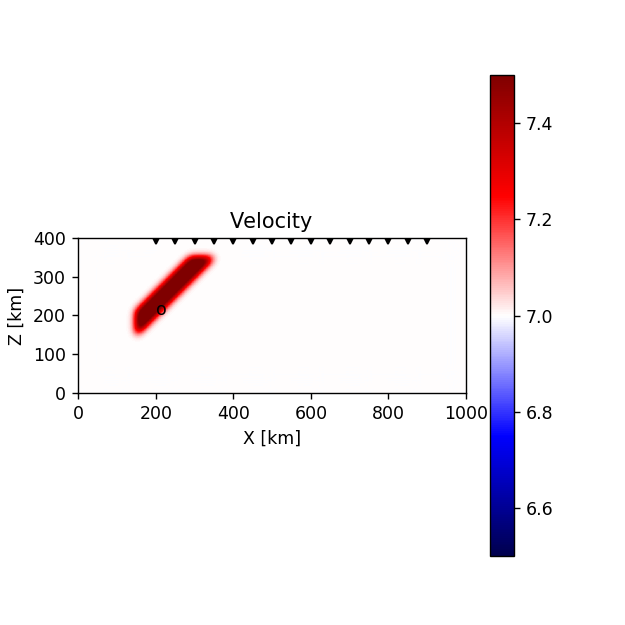

In [12]:
fig = plt.figure(figsize=(5,5))
image = plt.imshow(vpv.T/1000, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=6500/1000, vmax=7500/1000)
plt.colorbar()
plt.title('Velocity')  
plt.xlabel('X [km]')
plt.ylabel('Z [km]')
plt.gca().invert_yaxis()
plt.text(isx, isz, 'o')
for i in range(len(irx)):
    plt.plot(irx[i], irz[i], 'vk')
plt.ion()
plt.show(block=False)

In [29]:
np.shape(vp)

(1000, 400)

In [251]:
dx/(7/6)/np.sqrt(2)/3000

0.20203050891044214

In [13]:
@jit(nopython=True,parallel=True) # use JIT for C-performance
def update_v(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu):
    for i in range(ni1,ni2):
        for j in range(nk1, nk2):
            dsxx =  9/8*(sxx[i+1][j]-sxx[i][j])/(dx)-1/24*(sxx[i+2][j]-sxx[i-1][j])/(dx)
            dszx = 9/8*(szx[i][j]-szx[i-1][j])/(dz)-1/24*(szx[i+1][j]-szx[i-2][j])/(dx)
            dszz = 9/8*(szz[i][j+1]-szz[i][j])/(dz)-1/24*(szz[i][j+2]-szz[i][j-1])/(dx)
            dsxz = 9/8*(sxz[i][j]-sxz[i][j-1])/(dx)-1/24*(sxz[i][j+1]-sxz[i][j-2])/(dx)
            vx_new=(dsxx+dsxz)
            vz_new=(dszz+dszx)
            vx[i,j]=vx[i][j]+dt*(vx_new/rho[i,j]) 
            vz[i,j]=vz[i][j]+dt*(vz_new/rho[i,j])
    return vx,vz



<IPython.core.display.Javascript object>


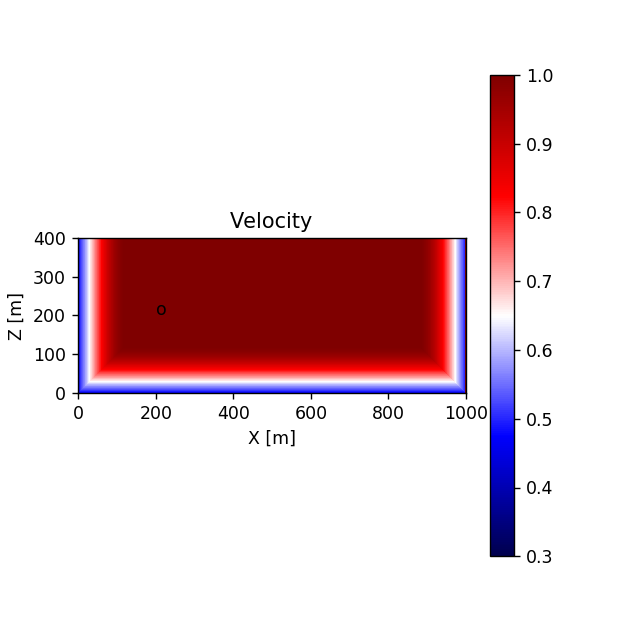

In [14]:

def generate_damp_guassian(nx,nz,ni1,ni2,nk1,nk2,absorb_thickness_n):
    #absorbpoint_x=np.arange(ni1,ni1+absorb_thickness_n-1)
    damp=np.ones((nx,nz))
    ####left boundary
    for i in range(ni1,ni2):
        for j in range(0,absorb_thickness_n):
            #print()
            damp[i,j]=(np.exp(-(0.007*(ni1+absorb_thickness_n-j))**2))
            
            
    #lower boundary
    for i in range(nk1,absorb_thickness_n):
        for j in range(0,nk2):
            #print()
            damp[i,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-i))**2))
            #print(j,damp[i,j])   
    # right boundary       
    for i in range(ni2-absorb_thickness_n,ni2):
        for j in range(0,nz):
            #print()
            damp[i,j]=(np.exp(-(0.007*(ni2-absorb_thickness_n-i))**2))
            #print(j,damp[i,j])    
    # left lower corner 
    for j in range(0,nk1+absorb_thickness_n):
        damp[j:ni1+absorb_thickness_n,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-j))**2))
                
    # right lower corner
    for j in range(0,nk1+absorb_thickness_n):
        damp[ni2-absorb_thickness_n:ni2-j,j]=(np.exp(-(0.007*(nk1+absorb_thickness_n-j))**2))   
    
            
    return damp


stencil=2
ni1=stencil+1
ni2=nx-stencil
nk1=stencil+1
nk2=nz-stencil
damp=generate_damp_guassian(nx,nz,ni1,ni2,nk1,nk2,120)
fig = plt.figure(figsize=(5,5))
image = plt.imshow(damp.T, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=0.3, vmax=1)
plt.colorbar()
plt.title('Velocity')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.gca().invert_yaxis()
plt.text(isx, isz, 'o')
plt.ion()
plt.show(block=False)    
    
    
    
    
    

In [15]:
damp

array([[ 0.47648406,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.47648406,  0.48223873,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.47648406,  0.48223873,  0.48801507, ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 0.47648406,  0.49962923,  0.49962923, ...,  0.49962923,
         0.49962923,  0.49962923],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [16]:
@jit(nopython=True,parallel=True) # use JIT for C-performance
def update_s(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu):
    for i in range (ni1, ni2):
        for j in range(nk1, nk2-1):
            ezx=9/8*(vz[i+1,j]-vz[i,j])/dx-1/24*(vz[i+2][j]-vz[i-1][j])/dx
            exz=9/8*(vx[i,j+1]-vx[i,j])/dz-1/24*(vx[i][j+2]-vx[i][j-1])/dz
            exx=9/8*(vx[i,j]-vx[i-1,j])/dx-1/24*(vx[i+1,j]-vx[i-2,j])/dx
            ezz=9/8*(vz[i,j]-vz[i,j-1])/dz-1/24*(vz[i,j+1]-vz[i,j-2])/dz
            #hTxx=(lamd[i,j]+2*mu[i,j])*exx+lamd[i,j]*ezz
            #hTzz=(lamd[i,j]+2*mu[i,j])*ezz+lamd[i,j]*exx
            #hTxz=(mu[i,j])*ezx+(mu[i,j])*exz
            sxx[i,j]=sxx[i,j]+((lamd[i,j]+2*mu[i,j])*exx+lamd[i,j]*ezz)*dt
            sxz[i,j]=sxz[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
            szz[i,j]=szz[i,j]+((lamd[i,j]+2*mu[i,j])*ezz+lamd[i,j]*exx)*dt
            szx[i,j]=szx[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
        ### free surface
        sxx[:,nk2]=sxx[:,nk2]+((lamd[:,nk2]+2*mu[:,nk2])*exx-(lamd[:,nk2]**2/(lamd[:,nk2]+2*mu[:,nk2])*exx))*dt
            #sxz[i,j]=sxz[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt
        szz[:,nk2]=szz[:,nk2]
            #szx[i,j]=szx[i,j]+((mu[i,j])*ezx+(mu[i,j])*exz)*dt                
    return sxx,sxz,szz,szx

In [17]:

import datetime

######here you could input a heterogenity vp and vs

def assemble_psv(dx,dz,rho0,vp,vs,dt,nt,nx,nz,irx,irz,isx,isz,src,damp):
    t1 = datetime.datetime.now() 
    rho=np.zeros((nx,nz))+rho0
    mu = np.zeros((nx,nz))+rho*vs**2
    lamd=np.zeros((nx,nz))+rho*vp**2-2*mu
    ##### initial the cycle
    vx = np.zeros((nx, nz))
    vz = np.zeros((nx, nz))
    sxx = np.zeros((nx, nz)) 
    sxz = np.zeros((nx, nz))
    szz = np.zeros((nx, nz))
    szx=np.zeros((nx, nz))
    seis = np.zeros((len(irx), nt))
    print(np.shape(seis))
    ir = np.arange(len(irx))
    v = max([np.abs(src.min()), np.abs(src.max())])
    stencil=2
    ni1=stencil+1
    ni2=nx-stencil
    nk1=stencil+1
    nk2=nz-stencil
    fig = plt.figure(figsize=(6,6))
    #extent = [np.min(),np.max(X),np.min(X),np.max(Y)]
    image = plt.imshow(vz.T, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=-1e-3, vmax=1e-3)
    #image = plt.imshow(vp.T/100000, animated=True, cmap=cm.seismic, interpolation='nearest', vmin=-0.001, vmax=0.001)
    plt.colorbar()
    plt.title('Wavefield vy')
    plt.xlabel('X [km]')
    plt.ylabel('Y [km]')
    plt.gca().invert_yaxis()
    plt.text(isx, isz, 'o')
    plt.ion()
    plt.show(block=False)
    #### free surface by image
    #plt.text(isx, isz, 'o')
    for i in range(len(irx)):
        plt.plot(irx[i], irz[i], 'vk')
    #fig.canvas.draw()
      
    for it in np.arange (nt):
        szz[:,nk2]=0
        #for n in range(0,stencil-1):
        #    szz[:,nk2+1+n]=-szz[:,nk2-1-n]
         #   sxz[:,nk2+n]=-sxz[:,nk2-n-1]
        vx, vz = update_v(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu)
        vx=vx*damp
        vz=vz*damp
        vz[:,nk2  :nz]  = 0.0;
        vx[:,nk2+1:nz]  = 0.0;
        vz[isx,isz]=vz[isx,isz]+src[it] 
        vx[isx,isz]=vx[isx,isz]+src[it] 
        ###for the receivers
        for k in np.arange(len(irx)):
            print(vz[int(irx[k]),int(irz[k])])
            seis[k,it]=seis[k,it]+vz[int(irx[k]),int(irz[k])]
        sxx,sxz,szz,szx = update_s(vx, vz, sxx, szz, sxz,szx, nx, nz, dt,dx,rho,ni1,ni2,nk1,nk2,lamd,mu)
        #sxx=sxx*damp
        #sxz=sxz*damp
        #szz=szz*damp
        #szx=szx*damp
        if (it % isnap) == 0:
            #print(np.shape(vz))
            image.set_data(vz.T)
            plt.plot
            fig.canvas.draw()
    t2 = datetime.datetime.now()   
    print(t2-t1)
    return vx, vz,seis








(15, 3000)


<IPython.core.display.Javascript object>


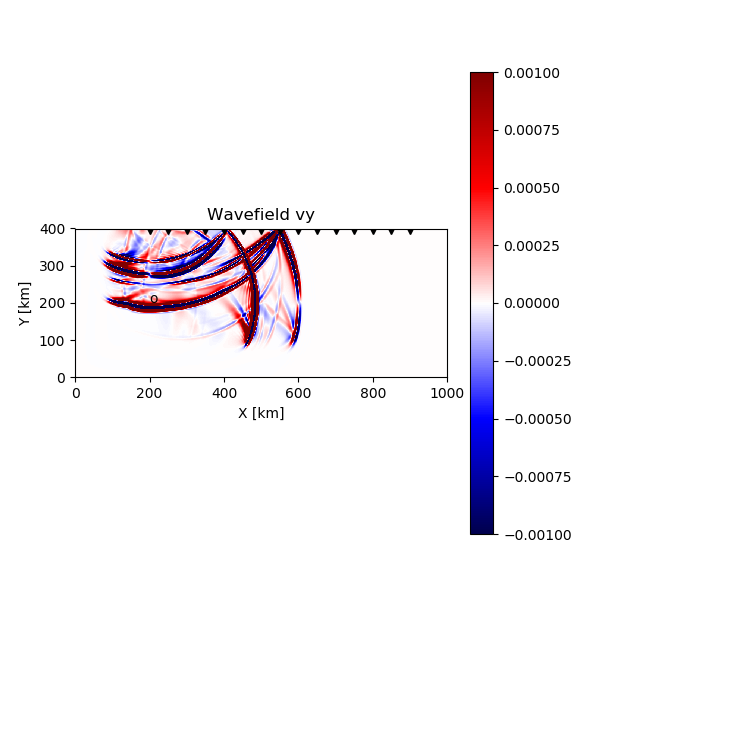

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


-2.35753669382e-143
4.15205285448e-180
3.95343812088e-260
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.38215377956e-142
-2.80097135922e-178
-3.79767030623e-257
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.94259331853e-141
1.72759458549e-176
3.09727603442e-254
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.56337767095e-141
-9.75782593683e-175
-2.16461964051e-251
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.59022826884e-140
5.05412229703e-173
1.30708723929e-248
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.82867935767e-139
-2.40345958101e-171
-6.87004704411e-246
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.09904225999e-139
1.05040387286e-169
3.16401917883e-243
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.15749774419e-137
-4.22226272617e-168
-1.28457422631e-240
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.6537280551e-137
1.56189490786e-166
4.62270704428e-238
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.48301912793e-136
-5.31894108118e-165
-1

8.2695339439e-99
-2.92927547388e-112
7.8954667532e-146
-2.30066357211e-196
-1.43350155867e-268
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.5269381475e-98
5.92393478841e-112
-7.17451962329e-146
5.71202968376e-195
1.29154762738e-266
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.10997082252e-99
6.11205492587e-111
-3.07334086965e-144
-1.34387614379e-193
-1.10157642301e-264
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.02095198017e-97
-1.04172709289e-110
2.59535487976e-143
2.99446392443e-192
8.90140597341e-263
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.07889907435e-96
-1.24487553916e-109
-4.87292433513e-143
-6.3148601674e-191
-6.81978997463e-261
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.87346895023e-97
1.50825741856e-109
-7.84140448031e-142
1.25924137362e-189
4.95749133569e-259
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.80807336985e-96
2.45221558875e-108
7.11987740285e-141
-2.37179211524e-188
-3.42155698686e-257
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.26275250551e-95
-1.43313376061e-108
-1.184623

4.28167408687e-72
-1.47437693066e-80
2.83665020034e-105
1.10484725266e-144
3.82544206937e-193
1.06626722702e-249
3.45845952089e-322
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.8945152784e-72
8.84221346809e-80
-2.83200273662e-104
6.02208255782e-143
6.0354973819e-191
-2.10364995975e-248
-1.7460279924e-320
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.27947219585e-71
3.52239716242e-79
-6.19915689632e-104
-2.15804697053e-142
-6.13137132476e-190
3.96395491596e-247
8.97573999456e-319
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.24956536485e-70
8.63817936331e-80
4.52567990464e-103
-1.1795409416e-141
2.72168557717e-189
-7.12712391889e-246
-4.42283020753e-317
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.55082077015e-70
-2.90108709866e-78
1.29754808038e-102
9.63456035306e-141
5.97427630737e-189
1.22132563949e-244
2.09436615983e-315
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.81738746852e-70
-8.07720842893e-78
-6.75265647112e-102
8.82728587757e-141
-1.8866992465e-187
-1.9919611409e-243
-9.53260253516e-314
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.011883

-1.30474158889e-52
2.96500401158e-58
-1.41169941108e-76
8.14067723107e-110
1.29120946275e-152
-2.94884728702e-202
-4.7007975644e-257
-6.04708188768e-318
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.66077657246e-52
4.64662068514e-58
-5.24593684148e-76
-6.79006585667e-109
1.89402875177e-151
1.232952806e-201
3.33094944102e-256
1.15568174849e-316
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.81953561252e-52
-3.38847785996e-58
3.56565347972e-76
-1.78232770088e-108
-6.01953297883e-151
5.0106775354e-201
-1.03416705365e-255
-2.12123076687e-315
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.6397209906e-52
-3.67902952124e-57
5.79283708422e-75
9.55244756087e-108
-3.84810908756e-150
-7.11416181265e-200
-7.85847534921e-255
3.73608955999e-314
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.24539081446e-51
-9.00750764433e-57
8.08254659038e-75
3.54664998315e-107
1.97984616855e-149
1.53071116482e-199
1.44436583355e-253
-6.30784374609e-313
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.20038481183e-51
-5.95671331733e-57
-3.89520455361e-74
-1.21215633923e-106
6.84259754498e-149
1.90

-2.19744387829e-37
-6.55419003569e-42
-6.31916952598e-56
-6.30660049212e-84
3.6017536542e-121
-1.16861854707e-167
-5.63729017848e-218
-4.01244664895e-272
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.644162393e-37
-3.3159896187e-41
-1.7527887359e-54
3.0236242518e-82
1.24309978276e-120
-1.5237255631e-166
5.42022192102e-218
6.50448880378e-272
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.55435173074e-39
-7.21056012652e-41
-3.83185409947e-54
6.15721606061e-82
-4.4798595501e-120
3.47383110323e-166
1.61142721782e-216
1.36910847653e-270
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.70796199734e-37
-7.67405045404e-41
1.797973659e-54
-1.98655647074e-81
-2.30753638544e-119
3.15116937651e-165
-6.23713593644e-216
-1.18997922434e-269
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.02946047192e-36
7.30230468361e-41
2.83778860324e-53
-9.96221225537e-81
4.65661865096e-119
-9.0426448304e-165
-3.24538512693e-215
1.6113343946e-269
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.83232826142e-36
5.42411748115e-40
5.78416943193e-53
1.60133951973e-81
3.91898025969e-118
-6.3804689644e-164

4.95338843728e-26
-4.0615020625e-29
-1.61308695375e-38
-1.57375391904e-61
4.74445240889e-97
-1.17693720881e-139
-1.02764958159e-186
1.9365105719e-237
-6.71307826849e-291
0.0
0.0
0.0
0.0
0.0
0.0
2.00529572773e-25
-2.49184015142e-28
-4.2462233478e-38
-3.3425105415e-61
1.60319858893e-95
-3.20456427317e-138
8.25471067391e-186
-1.08870650751e-236
4.66616107876e-290
0.0
0.0
0.0
0.0
0.0
0.0
4.39672917243e-25
-5.92749643137e-28
-3.73833170556e-38
4.07203934884e-61
2.32165700794e-95
-1.60752695623e-138
2.05056824335e-185
-3.43925574628e-236
4.77237126791e-290
0.0
0.0
0.0
0.0
0.0
0.0
6.93407873766e-25
-9.09679564046e-28
9.21180880253e-38
3.35270247608e-60
-1.30720752223e-94
4.59754138503e-137
-1.67270345605e-184
3.57395275146e-235
-1.96294794044e-288
0.0
0.0
0.0
0.0
0.0
0.0
7.3439090813e-25
-7.1464220308e-28
4.03047570175e-37
4.60243427714e-60
-4.8188160085e-94
7.43022707968e-137
-4.15507327969e-184
3.5105154648e-235
6.51274610104e-288
0.0
0.0
0.0
0.0
0.0
0.0
1.19139035429e-25
8.71265317194e-28


7.76152352931e-18
2.32283369242e-19
5.03745962365e-26
-2.50082152287e-45
1.3048106297e-75
-1.67151799087e-115
-1.17323010015e-160
1.20437535047e-208
-9.1574298545e-260
-2.66177988346e-312
0.0
0.0
0.0
0.0
0.0
-6.83874225437e-17
-6.49518576714e-19
5.45476880678e-26
2.33498996226e-44
1.06843742519e-76
-4.71743053755e-115
7.27339528824e-160
-2.26758293075e-208
1.06072343929e-258
4.80258742613e-312
0.0
0.0
0.0
0.0
0.0
-2.02796104795e-16
-2.37381177914e-18
-2.44329302714e-26
6.95623055004e-44
-1.03616912647e-74
1.02043989618e-114
2.595193257e-159
-2.40809829985e-207
1.18858888777e-258
7.5929682501e-311
0.0
0.0
0.0
0.0
0.0
-3.90636946518e-16
-4.85700644296e-18
-2.44404027562e-25
4.0416971478e-44
-2.33179932915e-74
7.04587685317e-114
-7.55464465243e-159
3.64219279645e-207
-2.83355090323e-257
-3.99467569417e-310
0.0
0.0
0.0
0.0
0.0
-5.90635372074e-16
-7.3098984993e-18
-5.61291881196e-25
-2.76803399952e-43
3.23580378438e-74
1.50685919705e-114
-4.70865234843e-158
4.74460001944e-206
-1.87916075292

3.46397042871e-10
-1.56207672676e-11
-1.18144700469e-16
-1.81964287149e-31
-8.69814752324e-58
1.23378704089e-96
-7.41664996231e-138
5.79970511379e-183
-1.634123839e-231
9.45183726526e-282
0.0
0.0
0.0
0.0
0.0
1.38893791925e-10
-2.31907011024e-11
4.55552893973e-17
-3.45172662706e-30
9.95414013146e-58
3.60148750427e-94
1.68145696725e-136
2.46630771366e-182
-1.4350305532e-230
-4.54743100732e-281
0.0
0.0
0.0
0.0
0.0
-3.84388738254e-10
-2.79603231062e-11
4.01928392045e-16
-7.63112876344e-30
7.76375821765e-57
7.67288285616e-94
3.91987722046e-136
-5.16646572948e-182
2.26872505593e-230
-2.02894714712e-280
0.0
0.0
0.0
0.0
0.0
-1.39114025444e-09
-2.53725576215e-11
9.10004552553e-16
-4.69126505474e-30
1.20558109909e-56
-1.40752356744e-93
-1.15738817855e-135
-4.2644536555e-181
2.81415841229e-229
1.20879028092e-279
0.0
0.0
0.0
0.0
0.0
-3.06288192676e-09
-9.54984235149e-12
1.34758200252e-15
1.89082700722e-29
-1.95277510026e-56
-9.55932937217e-93
-6.50817714117e-135
1.60527588702e-181
-2.47346166029e-

-0.000653339880621
-5.12135589604e-05
1.788822617e-10
-4.26101300585e-20
3.92801021395e-43
2.06771793466e-77
-2.09500426554e-117
8.93632459461e-162
-7.58320147279e-208
3.27167200926e-256
-1.3571237793e-306
0.0
0.0
0.0
0.0
-0.000747332484449
-7.60359688831e-05
2.36316937046e-10
2.91100866759e-20
2.59746585908e-44
6.2827542837e-77
-3.36976016727e-117
-1.29885674391e-160
-9.46904809452e-207
4.61116016339e-255
2.72183510993e-305
0.0
0.0
0.0
0.0
-0.000835549486023
-0.000108650462115
2.59021578572e-10
1.93496975278e-19
-1.86872344499e-42
5.48428887534e-78
1.15074003733e-116
-3.48125917116e-160
-2.30842411217e-207
-2.79616879917e-255
2.38108969034e-305
0.0
0.0
0.0
0.0
-0.000912383100244
-0.000150218316592
2.14231241248e-10
3.72161156831e-19
-4.6271032759e-42
-4.16051356645e-76
5.5272428701e-116
8.30033295368e-160
1.35141976731e-205
-8.76018187982e-254
-6.46558089192e-304
0.0
0.0
0.0
0.0
-0.000971830015544
-0.000201670165004
5.85559134195e-11
3.21094320849e-19
-2.07040388301e-42
-1.01636053082

-0.000230019614787
0.000638124065781
-0.000352821880781
3.05179327695e-13
1.4683814124e-30
-7.66967689291e-62
-6.735153754e-100
3.05236663012e-141
-1.65093412086e-185
-2.95650348229e-232
-1.33368142689e-281
0.0
0.0
0.0
0.0
-0.000240912951428
0.000491951088014
-0.000410797065403
-1.57524996524e-12
1.47157300136e-30
-7.54323758765e-62
1.82352277217e-99
6.52932585567e-141
1.80326329519e-185
2.51060823985e-231
-1.54839357212e-279
0.0
0.0
0.0
0.0
-0.000243421085816
0.000355131445848
-0.000467378323215
-3.96934787453e-12
-2.09144449161e-30
2.41577612662e-61
9.27478481977e-99
-1.41252718707e-140
2.31070294597e-184
8.15748275167e-231
-1.07059684075e-279
0.0
0.0
0.0
0.0
-0.000239494305115
0.00023131036513
-0.000519441809644
-5.6876492999e-12
-1.05889600331e-29
1.00622931464e-60
8.81731728249e-99
-9.25442597981e-140
2.38261437475e-184
-2.47921281011e-230
2.76617985197e-278
0.0
0.0
0.0
0.0
-0.000230863859266
0.000122864969384
-0.000563565909789
-5.11610184594e-12
-1.74259449108e-29
1.13210705854e

-1.9948326007e-05
-3.19576899274e-05
5.99179638519e-05
2.44358084264e-08
4.97805029167e-21
1.20906814632e-49
6.28202819234e-85
-1.87055943201e-124
-1.11679630421e-167
-9.31686125335e-212
-4.01764515399e-258
9.76007819795e-307
0.0
0.0
0.0
-1.8968414582e-05
-2.97384171804e-05
2.89391004723e-05
5.3940827902e-08
5.26141881248e-21
-4.72426499855e-49
2.58707311438e-84
1.53714629868e-124
2.64477722093e-166
-6.9394907753e-211
-1.18992527814e-257
-1.25694773116e-306
0.0
0.0
0.0
-1.80577651611e-05
-2.77054320813e-05
4.45941710531e-06
9.93692059586e-08
-2.31711019281e-21
-1.72039993042e-48
2.59721566673e-84
1.85137283265e-123
7.06179597122e-166
-2.04830779399e-211
4.33315910765e-257
-1.92526371697e-305
0.0
0.0
0.0
-1.72099131123e-05
-2.58455743701e-05
-1.41277973381e-05
1.62053278593e-07
-2.04912172367e-20
-2.11092964857e-48
-9.31895025241e-84
3.29104012301e-123
-1.02718121315e-165
8.13556763446e-210
2.47672987564e-256
7.43950759293e-306
0.0
0.0
0.0
-1.64191437849e-05
-2.41503240871e-05
-2.754991

-5.2146277907e-06
-8.49348767052e-06
-8.02539764147e-06
-3.64428700377e-05
-4.67752916334e-14
-5.02436448561e-38
-2.59572302251e-71
5.73014757065e-109
-2.09093643137e-149
-2.20110410505e-192
2.02264428627e-237
-4.35578239907e-285
0.0
0.0
0.0
-5.06711003204e-06
-8.1365936221e-06
-8.11838691443e-06
4.75951896841e-05
-6.18686249436e-14
-8.64435381252e-38
2.15375807355e-71
2.30893055492e-108
-4.51549437881e-149
-2.37405226406e-192
-1.08148466484e-237
-7.0206624276e-284
0.0
0.0
0.0
-4.92709895147e-06
-7.82309988808e-06
-8.25256803285e-06
0.000132285779118
-3.9934766447e-14
-2.61162145977e-38
1.90029275734e-70
2.04078307513e-108
6.65183785276e-149
1.76766445375e-191
-2.81832034557e-236
-2.95165579304e-284
0.0
0.0
0.0
-4.79617632964e-06
-7.55909525193e-06
-8.43922859836e-06
0.00021386479561
3.2932064963e-14
2.56455369959e-37
3.76614805263e-70
-1.02813537691e-107
5.44875593699e-148
6.48258653225e-191
-4.18674442558e-236
1.05794782674e-282
0.0
0.0
0.0
-4.67674794211e-06
-7.35068879771e-06
-8.69

-9.43518431866e-07
5.37642022985e-06
1.06188798034e-05
-3.97707066646e-05
-2.59170596915e-11
1.7371817601e-29
7.68437827606e-59
-2.80343951971e-95
4.96201236662e-134
-1.71718082065e-175
-9.91986739035e-219
1.66212549138e-263
-5.17337229901e-310
0.0
0.0
-3.6652776859e-08
4.98303105409e-06
9.53663564064e-06
-2.89015279766e-05
-1.12383813852e-10
-2.09566312145e-28
9.08530933419e-59
3.95190572898e-94
8.31521516696e-133
-3.95045191136e-174
-1.86101571834e-217
-1.04704055657e-263
4.57318654201e-310
0.0
0.0
7.41577815977e-07
4.38530502263e-06
8.13517389995e-06
-1.95637266725e-05
-2.58159957946e-10
-5.66213221794e-28
-1.03372127629e-58
1.20757520994e-93
1.79176591371e-132
-8.21419872335e-174
-3.12226631814e-217
-2.4612206354e-262
9.19524543493e-309
0.0
0.0
1.38120461333e-06
3.62826247574e-06
6.50393710467e-06
-1.17456698387e-05
-4.67758065725e-10
-7.5663729822e-28
-6.70586961314e-58
9.02853449346e-94
-1.41370934904e-132
1.50649676881e-173
1.33950766327e-216
-3.17968231928e-262
7.10009246615e-3

-2.61685226525e-06
-9.86147940654e-06
-5.29991252598e-06
4.26043419272e-05
-3.90191689793e-05
2.10192035091e-21
-1.06062914753e-48
8.32248285352e-83
-1.46149712636e-120
1.74618345854e-159
-3.26633067771e-201
1.27941229055e-245
-1.39341492331e-290
0.0
0.0
-2.87198944149e-06
-9.48966576782e-06
-5.2510149737e-06
3.66818104109e-05
-4.5556113846e-05
-3.00892878972e-22
-4.59272327026e-49
7.12603256727e-82
-5.12087577432e-119
-3.27333309416e-159
-4.03512156587e-202
1.22055187115e-244
3.60191407959e-290
0.0
0.0
-3.07816864647e-06
-8.86773814121e-06
-5.1990965223e-06
3.11426484067e-05
-5.22018630516e-05
-5.89151783769e-21
2.88085549756e-48
1.49212243049e-81
-1.27672016661e-118
-2.23797418018e-158
3.08075402658e-200
1.13625870637e-244
2.668378915e-289
0.0
0.0
-3.24085572857e-06
-7.99830691531e-06
-5.13843161543e-06
2.60916315149e-05
-5.87412574924e-05
-1.34324044059e-20
9.33407567503e-48
3.80873194044e-82
-1.26251903754e-119
-3.2693087049e-158
7.95350079691e-200
-1.2057930067e-243
1.13549623601e

1.67923104929e-05
-4.73493629845e-06
-1.93562930231e-06
-8.93006078529e-06
1.57241540626e-05
-1.55962603277e-15
8.71239049948e-40
-6.54851031853e-71
-2.08545651206e-106
-1.50198679754e-145
-2.59980631149e-185
1.42343401291e-228
-4.17141904591e-272
6.77533959031e-318
0.0
2.01421452034e-05
-5.52570641269e-06
-2.31487664021e-06
-8.87279515727e-06
1.29511086244e-05
-1.67408047472e-15
3.53790351172e-39
-5.21965191557e-71
-3.84688309364e-106
1.57743253844e-144
-4.24105050954e-186
-2.21580380232e-227
-2.16048924828e-271
1.05522145386e-317
0.0
2.36722773874e-05
-6.12581339306e-06
-2.69728546861e-06
-8.7826862425e-06
8.65871403412e-06
-9.07770640953e-16
6.3640326627e-39
1.55376766473e-70
1.44964045363e-106
5.36350088864e-144
2.13762285091e-184
-6.83045865109e-227
4.02727862116e-272
-7.84646007665e-317
0.0
2.73144446162e-05
-6.39709459291e-06
-3.07088092046e-06
-8.66453402889e-06
2.76908795967e-06
1.04164370457e-15
4.87120043972e-39
6.59227587452e-70
2.596883978e-105
3.50222345408e-144
5.8641075

-2.33389153481e-05
9.76221257876e-05
2.27512354917e-07
-3.95480075481e-06
0.0002052046755
8.6647405171e-12
-9.70042216742e-32
1.98973556942e-60
-2.35283336585e-94
3.98633583548e-131
-1.54384248853e-170
-1.3025079379e-211
8.60375768883e-255
5.08689893368e-300
0.0
-2.27087851243e-05
-1.36207532504e-05
5.33919798289e-07
-3.86556230628e-06
0.000189577601597
1.50107410215e-11
2.51873671803e-31
2.24123463622e-60
-6.62228612786e-94
4.42723332812e-131
-9.37473552351e-170
-7.03823432254e-211
8.55589429975e-254
1.27451440174e-298
0.0
-2.17598550456e-05
-0.000130939044555
8.65359174467e-07
-3.77974922027e-06
0.000171214959549
2.28734286945e-11
9.38988033947e-31
-1.92442439518e-60
-6.28608497443e-94
-1.32489534006e-130
-1.28883899953e-169
-5.83998304644e-211
1.11046067804e-253
2.09154016886e-298
0.0
-2.05897355015e-05
-0.000249921428938
1.22196591079e-06
-3.69723139612e-06
0.00015092739097
3.0577471373e-11
1.71000622211e-30
-1.43022640835e-59
1.64086210786e-93
-6.55061878884e-130
3.80421289439e-16

8.64053940634e-06
4.72261379996e-05
-5.36071945869e-07
-2.34580164866e-06
-1.86325874238e-05
-2.75292427171e-06
6.307846122e-25
1.97527760513e-51
6.40728701773e-83
3.30020786723e-118
4.41398238991e-156
2.66991613477e-196
1.36950959592e-237
-4.98910613727e-282
0.0
9.73461132945e-06
4.12284588727e-05
-3.80459900598e-06
-2.43169055905e-06
-1.72707968386e-05
-3.88052564072e-06
-4.46237164029e-24
-8.9888598352e-51
5.38280708861e-83
-2.76097728797e-119
1.75020855203e-155
-2.0387565732e-195
2.18880633505e-237
-7.9559571468e-281
0.0
1.08327131767e-05
3.89592728306e-05
-6.55898564913e-06
-2.53842670687e-06
-1.60301339015e-05
-5.30058089129e-06
-1.2964191616e-23
-3.16870252028e-50
-1.44296912626e-82
-1.99789792403e-117
1.65855761124e-155
-7.64795131281e-195
-7.72900505843e-237
-1.31000549335e-280
0.0
1.19106812934e-05
3.93990970438e-05
-8.29866615861e-06
-2.66460542997e-06
-1.49033399142e-05
-7.04487800384e-06
-2.1899062192e-23
-5.40918560964e-50
-6.51751309579e-82
-5.45876865975e-117
-7.6629577

1.53258827165e-05
8.42394358757e-06
-2.77973746896e-05
1.6632231383e-05
-4.24186424694e-06
-0.000101453742093
1.5765161154e-18
2.08930292784e-43
3.38743237244e-73
-5.96516609636e-107
-4.09406733069e-144
-1.40067100347e-182
-3.21584045574e-223
6.96565779253e-266
1.21700521608e-310
1.5039349096e-05
8.38735601704e-06
-0.00014815944715
1.70853577855e-05
-4.12740359493e-06
-0.000109543867939
1.08211960555e-18
1.53559638417e-42
3.33993440518e-73
-4.49899435731e-107
2.72946781922e-143
-8.62631884852e-182
-1.20238860142e-222
1.21553165704e-265
-2.62398648824e-310
1.47306669161e-05
8.81840859586e-06
-0.000268373883601
1.69291520308e-05
-4.02150075918e-06
-0.000118630415669
-6.85104106519e-19
3.47990414795e-42
-4.97741734046e-73
1.88947547513e-106
1.01209767456e-142
-1.29796734079e-181
-3.48343235294e-223
-4.05265710466e-265
-2.03468665322e-309
1.43960093495e-05
9.54355611147e-06
-0.000383157243796
1.61019195731e-05
-3.92357842882e-06
-0.000128396506081
-3.97484258198e-18
4.43892728384e-42
-2.83

-2.84585271201e-06
1.26619621526e-06
8.54046746642e-05
-3.59934282478e-07
-2.10701824194e-06
0.000320392872655
-3.23363911347e-14
1.99466995475e-35
3.5752243111e-64
1.28534736127e-96
-7.136944398e-132
-1.61266027878e-171
-2.6959012142e-209
-4.4822974722e-251
7.67042637091e-295
-3.45214123223e-06
1.94951692065e-06
7.89012731104e-05
6.04939795915e-07
-2.06429858577e-06
0.000282951455379
-2.95238304001e-14
9.18140830235e-36
1.228616992e-63
4.96856937002e-96
-2.53038990691e-131
-5.41895695473e-169
5.39106653341e-210
-9.02859342016e-251
2.77105328083e-294
-4.04372450081e-06
2.62139242419e-06
7.34227812454e-05
1.27933720422e-06
-2.02421958142e-06
0.000241676957273
-1.51655011278e-14
-3.38143580451e-35
2.05868627371e-63
7.67186675734e-96
-2.89183843809e-131
-1.49631779771e-168
2.29889565318e-208
1.78426460764e-250
-1.3567315339e-294
-4.62181827701e-06
3.20598413149e-06
6.86846483401e-05
1.69648070681e-06
-1.9864949324e-06
0.000198288824905
1.29897521616e-14
-1.17526603181e-34
9.68744572499e-6

-1.40733856514e-05
8.42457958714e-06
7.49978454422e-06
8.29707653759e-07
-1.00652950522e-06
-3.0180723647e-05
-2.77188094294e-10
5.45242216104e-29
-3.00767801055e-55
2.02688862959e-86
1.02403538488e-120
4.79912711797e-157
-4.48929588969e-196
1.63394427383e-238
-1.21625924158e-279
-1.4082349242e-05
8.35784024443e-06
7.17135922132e-06
3.26224486096e-07
-9.13959489213e-07
-2.66441225434e-05
-6.36379150644e-10
-4.57456037417e-29
-4.19884443687e-55
3.15965603548e-86
4.48012666531e-120
7.07316728021e-157
2.44300082029e-196
1.90553800454e-236
-2.49034756191e-279
-1.40675564432e-05
8.2273124469e-06
6.76185318269e-06
-2.24768812567e-07
-8.17520130541e-07
-2.35367582269e-05
-1.15143269168e-09
-2.66776247339e-28
-8.61042630117e-56
-1.73948897352e-87
7.15320684925e-120
-1.02736344648e-156
3.95489982527e-195
4.9926972272e-236
5.34766761503e-279
-1.40320066201e-05
8.05795563037e-06
6.22877736421e-06
-7.77749209341e-07
-7.20612027873e-07
-2.08214805892e-05
-1.81246720263e-09
-5.87795862001e-28
1.2638

-9.48977229192e-06
4.41782366778e-06
5.12079195083e-06
0.000153450718567
-1.59777082718e-06
-2.88988508282e-06
-1.20730660288e-05
1.53914068976e-22
3.17069006745e-47
5.41434730848e-77
7.35420948011e-110
-2.42788826607e-145
-2.76664028399e-183
1.97519739133e-223
1.98396897629e-265
-8.94826499722e-06
4.27213625564e-06
4.77960620037e-06
0.000110204110861
-1.55560222177e-06
-2.78832208357e-06
-1.53808394429e-05
1.72727926026e-22
4.5853993932e-47
8.90764506846e-77
-1.60951834641e-110
-1.54861008639e-145
-5.74953762129e-183
8.24255775573e-223
1.20381065049e-264
-8.3551458124e-06
4.16719071546e-06
4.43179277672e-06
6.0317255606e-05
-1.51177865968e-06
-2.69452106875e-06
-1.92578890771e-05
8.14635562264e-23
2.22069188516e-47
2.45200271161e-77
-4.10439104611e-109
9.65240319717e-145
2.341466104e-183
7.51882255692e-223
1.46095891496e-264
-7.71468907816e-06
4.09784966475e-06
4.10609059066e-06
5.67437342453e-06
-1.46766950577e-06
-2.60776353176e-06
-2.37610018817e-05
-1.97062456865e-22
-8.7483724929

-4.66938943659e-06
1.56747087688e-06
1.13335597985e-06
4.9606155335e-05
-6.13424777884e-07
-1.56611676926e-06
7.20180873863e-05
-1.05138334071e-17
-2.4437919601e-40
1.36722372241e-68
2.66799647603e-100
4.05152016871e-134
3.01443399937e-171
1.00448933731e-210
3.47980474073e-251
-4.49259342086e-06
1.23438423968e-06
1.25954666028e-06
4.93612254185e-05
-5.98996138889e-07
-1.55200424315e-06
0.000133739875623
7.62656005488e-19
-9.98089931225e-40
9.3699770765e-68
-2.12292077928e-99
8.01237775652e-134
-1.54662371828e-171
9.02009525001e-210
3.5717779333e-251
-4.25845484114e-06
8.87688138946e-07
1.40828771126e-06
4.81768272682e-05
-5.85273952728e-07
-1.53798127203e-06
0.000194497618239
2.27920522937e-17
-1.93501633026e-39
2.09271584737e-67
-7.28882877101e-99
1.3146264649e-134
-2.30854456643e-170
1.82694149255e-209
-1.84378523361e-250
-3.98114752392e-06
5.36046919085e-07
1.57197966237e-06
4.6303255899e-05
-5.71866688898e-07
-1.52380096249e-06
0.000251892028692
5.38518729481e-17
-2.23890817298e-39

-4.54456357413e-07
-4.60050830258e-06
7.70898415518e-06
5.44356191201e-06
-9.95490698131e-07
-1.09498658423e-06
-0.00011131335587
5.87332099156e-14
-2.50234881592e-33
-1.60699566841e-59
4.60747409456e-90
9.49059355068e-124
-1.35518907122e-159
-1.1482533035e-197
8.62700362423e-238
-4.36368646897e-07
-4.75467270053e-06
7.80144278645e-06
5.13257273745e-06
-9.37791432045e-07
-1.08395071764e-06
-0.000108421464332
3.68058360603e-14
-2.93379714179e-33
-3.70957562999e-59
-2.73058697827e-90
-1.9272846902e-123
5.05024287909e-160
-7.12396641833e-198
7.31595776288e-238
-4.20802023061e-07
-4.93099869935e-06
7.8751322734e-06
4.84845351311e-06
-8.61575303372e-07
-1.07304783592e-06
-0.000104014630055
3.37889442329e-15
-8.57872516199e-34
-4.66866003837e-59
-2.73791500067e-89
-1.02810589302e-122
9.24160744264e-159
5.51796751575e-197
-4.41072298087e-237
-4.07472517962e-07
-5.13915256313e-06
7.92749223387e-06
4.59405340117e-06
-7.69274964987e-07
-1.06219209167e-06
-9.84917340012e-05
-2.03134081639e-14
5.5

8.96538874129e-07
-3.47429264335e-06
5.16235001813e-06
3.18646793099e-06
-1.77333479586e-07
-1.01896963409e-06
-4.09253134592e-06
-3.04407977246e-09
-4.19964018838e-27
8.43340236346e-52
1.04156173294e-80
3.01608842369e-114
2.70009452698e-148
7.9647166013e-186
5.19880254331e-225
9.91071785196e-07
-3.21268870199e-06
5.0861744083e-06
3.23573805644e-06
-1.63036789257e-07
-1.03531705215e-06
-3.70995197615e-06
-5.00334284531e-09
-9.35783128668e-28
3.4505931122e-51
2.457382577e-80
-5.47920307662e-113
5.2848862942e-148
-1.1605275026e-185
1.78769982947e-224
1.0866662149e-06
-3.04227472669e-06
4.98614109634e-06
3.27683035225e-06
-1.56677604489e-07
-1.04775296037e-06
-3.38160590484e-06
-7.47259799899e-09
8.50071998171e-27
6.83656961068e-51
2.90557489245e-80
-1.726659912e-112
9.26863704757e-149
-8.23995868434e-185
1.50344306882e-224
1.18295192604e-06
-2.95585281585e-06
4.85682437435e-06
3.30766837484e-06
-1.71930126105e-07
-1.0555143406e-06
-3.0988918703e-06
-1.02854589713e-08
2.50036253491e-26
7.

1.88412315747e-06
-5.59916038445e-06
-8.14859368757e-06
2.81533385645e-06
-9.62470829006e-06
-6.1643931111e-07
-9.23645435639e-07
-6.72945751287e-05
-3.58266140633e-21
6.56893489051e-44
-6.9417947444e-72
1.48372767432e-103
9.94632869528e-138
-4.71305324889e-174
-1.71010489372e-212
1.7784316023e-06
-5.60280440284e-06
-5.95309791419e-06
2.84001891767e-06
-4.75565977736e-06
-6.06366959043e-07
-9.0519138015e-07
-8.53925907628e-05
-7.20420710603e-21
7.11110912472e-44
-9.95359924747e-72
-4.65107626409e-104
-4.46442740392e-138
-1.26217233876e-174
-9.21432847409e-213
1.66478268953e-06
-5.60246403701e-06
-3.5014698733e-06
2.8666923922e-06
3.27894519888e-07
-5.95954245912e-07
-8.88157177447e-07
-0.000105504017097
-1.04389554887e-20
-2.85095324573e-45
-2.76705196535e-72
-7.77862215924e-103
-6.28589977078e-137
2.32622643462e-173
8.4128060985e-212
1.54392034031e-06
-5.59936488678e-06
-8.78817141944e-07
2.89351574619e-06
5.43528907592e-06
-5.85183236444e-07
-8.72421728842e-07
-0.000127086086544
-1.0

In [ ]:
vx, vz,seis= assemble_psv(dx,dz,rho0,vp,vs,dt,nt,nx,nz,irx,irz,isx,isz,src,damp)

In [1]:

plt.ioff()
plt.figure(figsize=(5, 5))

plt.subplot(121)
time = np.arange(2000) * dt
plt.plot(time, src[0:2000])
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

plt.subplot(122)
ymax = seis[1][0:2000].ravel().max()  
for ir in range(len(seis)):
    print(time-(irx[ir]-isx)/7000)
    plt.plot(time-(irx[ir]-isx)*dx/10000, 1000*seis[ir, 0:2000] + 1 * ir,'b')
    plt.xlim(0,80)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

NameError: name 'plt' is not defined

In [ ]:
plt.show()